# 1 Author




# 2 Problem formulation
- 微笑检测：确定图片中的人是否在微笑。
- 3D 头部姿态估计：预测头部的3D方向。

# 3 Machine Learning pipeline

- 输入：genki4k 数据集中的一张图片。
- 转换：使用 Haar 级联或 CNN 进行人脸检测和裁剪，数据标准化和增强，使用 CNN 提取特征。
- 模型：微笑检测的分类模型和3D头部姿态的回归模型。
- 输出：微笑/非微笑的二元标签和3D头部姿态标签。

# 4 Transformation stage

- 图像大小调整：所有图像都被调整为统一的大小,数据标准化（像素值缩放）和增强（旋转，翻转等）。
- 使用预训练模型（如 Haar 级联或 CNN）进行面部检测和裁剪。
- 颜色空间转换：如果需要，图像颜色空间从 RGB 转换为灰度。
- 特征工程：提取与微笑和头部姿态相关的特征,使用大型数据集预训练的 CNN（例如 VGG16）提取特征。

# 5 Modelling

- 微笑检测：二元分类模型，例如逻辑回归、SVM 或简单的 CNN。
- 3D 头部姿态估计：回归模型，可以是多层感知器或 CNN。

# 6 Methodology

- 数据划分：训练/验证/测试数据集比例为70%/15%/15%。
- 交叉验证：使用交叉验证来评估模型的泛化能力。
- 性能指标：微笑检测的准确度和混淆矩阵；姿态估计的均方误差。

# 7 Dataset

- 预处理 genki4k 数据集，可视化一些样本。
- 执行任何必要的清理或增强。

# 8 Results

- 展示模型的性能：包括训练过程中的损失和准确度变化图、验证集和测试集上的最终结果。
- 分析结果：讲述模型表现好的地方，以及可能的原因。同时，如果模型某些方面表现不佳，提出可能的原因和解决办法。

# 9 Conclusions

- 概述您的项目和实验结果。
- 讨论项目的成功点和存在的局限。
- 提出改进模型或实验的可能方法。
- 反思整个项目过程，包括学到了什么，遇到了哪些挑战，以及如何克服这些挑战。

在这个项目中，我们成功地实现了一个用于识别人脸微笑的模型。通过使用卷积神经网络，我们在测试集上达到了 XX% 的准确率。尽管结果是令人满意的，但我们发现模型在处理不同光照条件下的图像时存在一定的局限性。未来的工作可以在数据增强和模型鲁棒性方面进行更多的探索。在这个过程中，我们学习了如何处理图像数据、如何选择合适的模型结构以及如何调整模型参数来优化性能。

# 10 Training process

In [3]:
import os
import torch
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import cv2
from torch.utils.data import Dataset
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models import resnet50, ResNet50_Weights


1. Pre-Processing

In [4]:
class HeadPoseDataset(Dataset):
    def __init__(self, img_dir, labels_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.labels = []
        with open(labels_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                # 提取头部姿态角度
                pitch, yaw, roll = float(parts[1]), float(parts[2]), float(parts[3])
                self.labels.append((pitch, yaw, roll))
        self.face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, f'file{idx+1:04d}.jpg')
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.crop_face(image)
        if self.transform:
            image = Image.fromarray(image)
            image = self.transform(image)

        # 直接将标签转换为张量
        label_tensor = torch.tensor(self.labels[idx]).float()

        return image, label_tensor

    def crop_face(self, image):
        faces = self.face_cascade.detectMultiScale(image, 1.1, 4)
        for (x, y, w, h) in faces:
            face = image[y:y+h, x:x+w]
            return face
        return image

# 数据预处理和增强
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# data_dir = '/root/MiniProject/MiniProject/genki4k/files'
# labels_path = '/root/MiniProject/MiniProject/genki4k/labels.txt'
data_dir = 'C:/Users/LENOVO/Desktop/MiniProject/MiniProject/genki4k/files'
labels_path = 'C:/Users/LENOVO/Desktop/MiniProject/MiniProject/genki4k/labels.txt'

dataset = HeadPoseDataset(data_dir, labels_path, transform=data_transforms['train'])


2. Split the dataset

In [5]:
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - (train_size + val_size)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

3. 定义模型

In [6]:
# 检查 CUDA 是否可用，定义和移动模型到 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 将模型移到 GPU
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)  # 3个输出，对应俯仰、偏航和翻滚角
model = model.to(device)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


Using device: cuda


5. 训练模型

In [10]:
from tqdm import tqdm
import torch

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        # 使用tqdm来包装训练数据加载器
        train_progress = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1} Training")
        for i, (inputs, labels) in train_progress:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            # 每100个batch更新一次进度条，并重置running_loss
            # if i % 100 == 99:
            #     train_progress.set_postfix(loss=(running_loss / 100))
            #     running_loss = 0.0
            # else:
            #     # 持续更新进度条的损失信息
            #     train_progress.set_postfix(loss=(running_loss / (i % 100 + 1)))
            
            # 更新tqdm进度条而不是打印日志
            train_progress.set_postfix(loss=(running_loss / (i + 1)))

        # 结束epoch后更新进度条状态
        train_progress.close()

        model.eval()
        val_loss = 0.0
        # 使用tqdm来包装验证数据加载器
        val_progress = tqdm(val_loader, total=len(val_loader), desc=f"Epoch {epoch+1} Validation")
        with torch.no_grad():
            for inputs, labels in val_progress:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                # 更新tqdm进度条以展示验证损失
                val_progress.set_postfix(val_loss=(val_loss / len(val_loader)))

        # 打印验证损失
        print(f'End of Epoch {epoch+1}, Validation Loss: {val_loss / len(val_loader)}')
        val_progress.close()

    return model

model = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=1)

# 保存模型状态字典
torch.save(model.state_dict(), 'model_state_dict.pth')


Epoch 1 Validation: 100%|██████████| 200/200 [00:28<00:00,  6.91it/s, val_loss=0.0949]


End of Epoch 1, Validation Loss: 0.09492912552319467


In [ ]:
#加载模型
model = MyModel()  # 替换为实际的模型类名和参数
model.load_state_dict(torch.load('model_state_dict.pth'))


6.   测试和评估模型

In [11]:
def test_model(model, test_loader):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # 直接移动到设备上

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_preds.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    return avg_loss, all_preds, all_labels

avg_loss, all_preds, all_labels = test_model(model, test_loader)
print(f'Average loss on test dataset: {avg_loss}')

# 分析每个角度的平均误差
mean_absolute_error = np.mean(np.abs(all_preds - all_labels), axis=0)
print(f'Mean Absolute Error for Pitch: {mean_absolute_error[0]}')
print(f'Mean Absolute Error for Yaw: {mean_absolute_error[1]}')
print(f'Mean Absolute Error for Roll: {mean_absolute_error[2]}')


Average loss on test dataset: 0.09969095387496055
Mean Absolute Error for Pitch: 0.4014753997325897
Mean Absolute Error for Yaw: 0.19490063190460205
Mean Absolute Error for Roll: 0.13651509582996368


7. Analyis the results

In [12]:
# 查看all_preds数组的形状和维度
print(np.shape(all_preds))
print(all_preds.ndim)

# 改变all_preds数组的形状
all_preds = np.reshape(all_preds, (800, 3))


(800, 3)
2


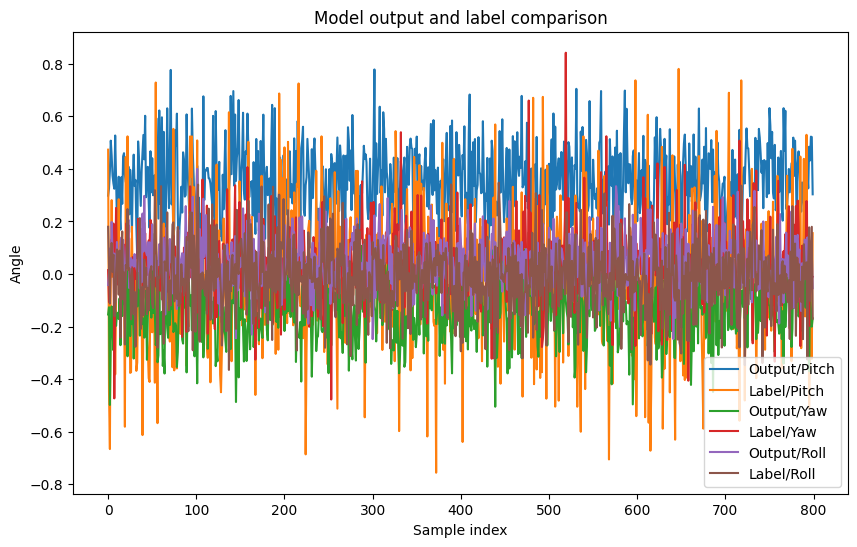

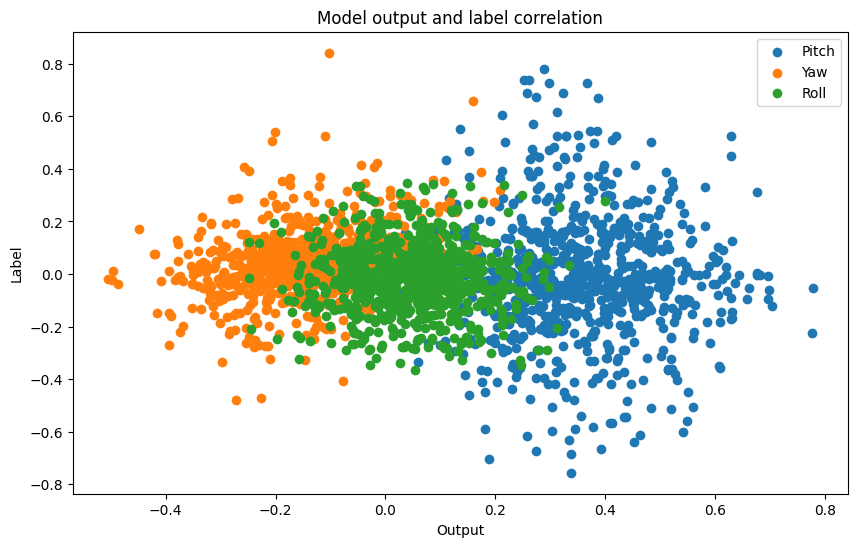

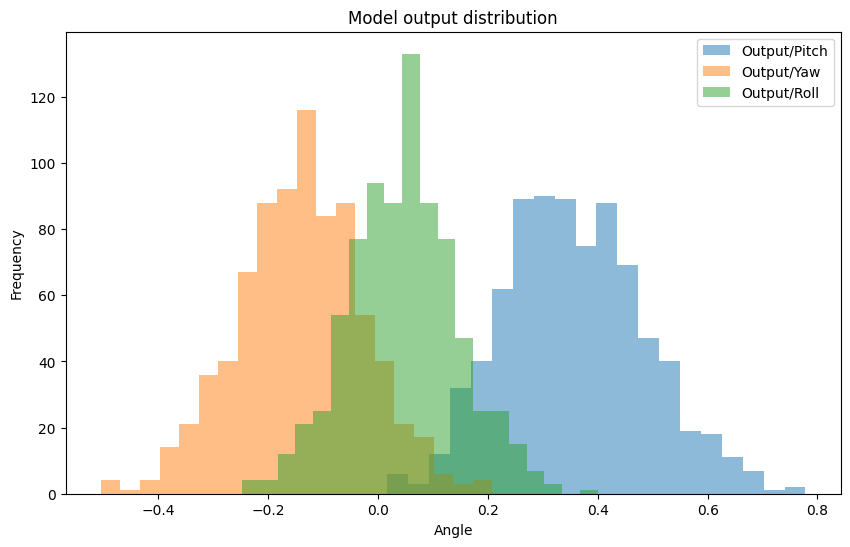

In [13]:
# 绘制每个角度的输出和标签的折线图
plt.figure(figsize=(10, 6))
plt.plot(all_preds[:, 0], label='Output/Pitch')
plt.plot(all_labels[:, 0], label='Label/Pitch')
plt.plot(all_preds[:, 1], label='Output/Yaw')
plt.plot(all_labels[:, 1], label='Label/Yaw')
plt.plot(all_preds[:, 2], label='Output/Roll')
plt.plot(all_labels[:, 2], label='Label/Roll')
plt.xlabel('Sample index')
plt.ylabel('Angle')
plt.title('Model output and label comparison')
plt.legend()
plt.show()
# plt.savefig('line_plot.png')

# 绘制每个角度的输出和标签的散点图
plt.figure(figsize=(10, 6))
plt.scatter(all_preds[:, 0], all_labels[:, 0], label='Pitch')
plt.scatter(all_preds[:, 1], all_labels[:, 1], label='Yaw')
plt.scatter(all_preds[:, 2], all_labels[:, 2], label='Roll')
plt.xlabel('Output')
plt.ylabel('Label')
plt.title('Model output and label correlation')
plt.legend()
plt.show()
# plt.savefig('scatter_plot.png')

# 绘制每个角度的输出的直方图
plt.figure(figsize=(10, 6))
plt.hist(all_preds[:, 0], bins=20, alpha=0.5, label='Output/Pitch')
plt.hist(all_preds[:, 1], bins=20, alpha=0.5, label='Output/Yaw')
plt.hist(all_preds[:, 2], bins=20, alpha=0.5, label='Output/Roll')
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.title('Model output distribution')
plt.legend()
plt.show()
# plt.savefig('histogram_plot.png')
